# LangGraph Quickstart

In [2]:
import os
import sys
import json
import datetime

from typing import Annotated
from typing_extensions import TypedDict

from IPython.display import Image, display
import networkx as nx
from pydantic import BaseModel, Field

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import OpenAI, ChatOpenAI
from langchain_community.tools import TavilySearchResults
from langchain.chat_models import init_chat_model
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Command, interrupt

from langchain_core.messages import ToolMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableConfig, chain
from langchain_core.tools import InjectedToolCallId, tool

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from lib.utils import set_chatgpt_env, set_langsmith_env, set_tavily_env

In [3]:
set_chatgpt_env()
set_langsmith_env()
set_tavily_env()

## Basic Chatbot

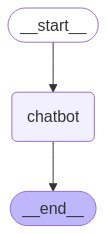

In [4]:
llm = ChatOpenAI(model='gpt-4-turbo')

class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

In [7]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break

    stream_graph_updates(user_input)

Assistant: As of my last update, there isn't a widely recognized public figure or well-known personality named Troy Stribling. The information on individuals with this name might be private or they may be local figures not documented extensively in accessible public sources or mainstream media. If Troy Stribling refers to someone specific from your personal knowledge or local context, providing additional details could help in discussing them more effectively. Alternatively, if you are looking for information related to a character, concept, or lesser-known individual named Troy Stribling, please provide more context for accurate and helpful insights.
Goodbye!


## Tavily Search

In [8]:
search_tool = TavilySearchResults(
    max_results=5,
    search_depth="advanced",
    include_answer=True,
    include_raw_content=True,
    include_images=True,
    # include_domains=[...],
    # exclude_domains=[...],
    # name="...",            # overwrite default tool name
    # description="...",     # overwrite default tool description
    # args_schema=...,       # overwrite default args_schema: BaseModel
)

In [11]:
search_tool.invoke({"query": "What happened at the last wimbledon"})

[{'url': 'https://www.the-independent.com/topic/wimbledon',
  'content': "Wimbledon - latest news, breaking stories and comment - The Independent Independent Wimbledon Rafael Nadal will retire after the Davis Cup with plenty of records and big numbers by his name A look at Rafael Nadal's 22 Grand Slam titles as he prepares to retire after the Davis Cup Rafael Nadal's farewell at the Davis Cup: When he'll play, how to watch on TV and more to know Tennis Channel takes Jon Wertheim off the air for comment about Wimbledon champ Barbora Krejcikova Mother ‘living in hell’ after girl, 8, dies in Wimbledon school crash AI umpires at Wimbledon will be game, set and match for tennis New Wimbledon system explained Wimbledon reveals new schedule for 2025 finals"},
 {'url': 'https://www.olympics.com/en/news/wimbledon-2024-mens-singles-final-carlos-alcaraz-retains-title',
  'content': "Tennis, Wimbledon 2024 men's singles final: Carlos Alcaraz beats Novak Djokovic to retain title Wimbledon 2024 men'

In [9]:
# This is usually generated by a model, but we'll create a tool call directly for demo purposes.
model_generated_tool_call = {
    "args": {"query": "euro 2024 host nation"},
    "id": "1",
    "name": "tavily",
    "type": "tool_call",
}
tool_msg = search_tool.invoke(model_generated_tool_call)

# The content is a JSON string of results
print(tool_msg.content[:100])

[{"url": "https://www.sportingnews.com/us/soccer/news/uefa-euro-2024-stadiums-host-cities-seating-ca


In [10]:
# The artifact is a dict with richer, raw results
{k: type(v) for k, v in tool_msg.artifact.items()}

{'query': str,
 'follow_up_questions': NoneType,
 'answer': str,
 'images': list,
 'results': list,
 'response_time': float}

In [14]:
print(json.dumps({k: str(v)[:200] for k, v in tool_msg.artifact.items()}, indent=2))

{
  "query": "euro 2024 host nation",
  "follow_up_questions": "None",
  "answer": "Germany is the host nation for UEFA Euro 2024. The tournament will take place across ten cities in Germany, including Berlin, Cologne, Munich, Frankfurt, Hamburg, Dortmund, Leipzig, Gelsenkirchen, Stu",
  "images": "['https://d.ibtimes.com/en/full/2492250/euro-2024-bids.jpg', 'https://as2.ftcdn.net/v2/jpg/05/78/75/31/1000_F_578753148_V47khSp6Dp6LqSI9JP2feCguhSGgNGi3.jpg', 'https://img.planetafobal.com/2021/10/sed",
  "results": "[{'url': 'https://www.foxsports.com/stories/soccer/euro-2024-host-germany-seeking-to-lift-nation-unexpected-run', 'title': 'Euro 2024: Host Germany seeking to lift the nation with unexpected ...', 'co",
  "response_time": "7.73"
}


### Chaining

In [15]:
llm = init_chat_model("gpt-4o-mini", model_provider="openai")

In [16]:
today = datetime.datetime.today().strftime("%D")
prompt = ChatPromptTemplate(
    [
        ("system", f"You are a helpful assistant. The date today is {today}."),
        ("human", "{user_input}"),
        ("placeholder", "{messages}"),
    ]
)

In [17]:
# specifying tool_choice will force the model to call this tool.
llm_with_tools = llm.bind_tools([search_tool])
llm_chain = prompt | llm_with_tools

@chain
def tool_chain(user_input: str, config: RunnableConfig):
    input_ = {"user_input": user_input}
    ai_msg = llm_chain.invoke(input_, config=config)
    tool_msgs = search_tool.batch(ai_msg.tool_calls, config=config)
    return llm_chain.invoke({**input_, "messages": [ai_msg, *tool_msgs]}, config=config)


tool_chain.invoke("who won the last womens singles wimbledon").content

"The last women's singles Wimbledon champion is Barbora Krejčíková, who won the title by defeating Jasmine Paolini with a score of 6–2, 2–6, 6–4 in the final. This victory took place in 2024."

### LangGraph with Search Tool

In [18]:
tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

[{'url': 'https://medium.com/@kbdhunga/beginners-guide-to-langgraph-understanding-state-nodes-and-edges-part-1-897e6114fa48',
  'content': "Beginner’s Guide to LangGraph: Understanding State, Nodes, and Edges — Part 1 | by Kamal Dhungana | Medium Beginner’s Guide to LangGraph: Understanding State, Nodes, and Edges — Part 1 LangGraph — State, Node and Edge Explained Mainly, we will focus on various components of LangGraph: State, Node, and Edges, and how to build a complete graph from these components. Once we understand these components, we will be able to build relatively complex LangGraph-based agents. Each node represents a specific function or operation that processes the current state. Nodes can perform computations, modify the state, or generate outputs based on the input they receive. Follow 1.2K Followers Data scientist with a passion for AI, Regularly blogging about LLM and OpenAI's innovations,Sharing insights for AI community growth Follow"},
 {'url': 'https://blog.langchain

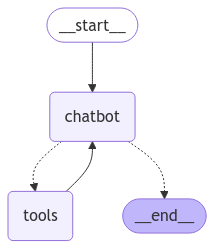

In [19]:
class State(TypedDict):
    messages: Annotated[list, add_messages]


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}
    
def route_tools(state: State):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")

    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


graph_builder = StateGraph(State)
llm = init_chat_model("gpt-4o-mini", model_provider="openai")
llm_with_tools = llm.bind_tools(tools)

graph_builder.add_node("chatbot", chatbot)

tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [20]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)
            
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Goodbye!


## Adding Memory to Chatbot

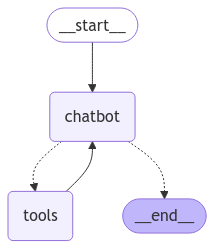

In [21]:
class State(TypedDict):
    messages: Annotated[list, add_messages]


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder = StateGraph(State)
llm = init_chat_model("gpt-4o-mini", model_provider="openai")

tool = TavilySearchResults(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

### Verify that Chat is saved

In [22]:
config = {"configurable": {"thread_id": "1"}}
user_input = "Hi there! My name is Will."

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================

Hello Will! How can I assist you today?


In [23]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, your name is Will. How can I help you today?


### Create a second thread

This verifies that memory is accessed using thread ID.

In [24]:
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

I don't have the ability to remember personal information, including your name, from previous interactions. How can I assist you today?


In [25]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Will.', additional_kwargs={}, response_metadata={}, id='454500cc-cb1e-467e-a71e-a4f2d1e55f78'), AIMessage(content='Hello Will! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 87, 'total_tokens': 99, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_06737a9306', 'finish_reason': 'stop', 'logprobs': None}, id='run-37a64d58-d299-4732-9101-56624fd27284-0', usage_metadata={'input_tokens': 87, 'output_tokens': 12, 'total_tokens': 99, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), HumanMessage(content='Remember my name?', additional_kwargs={}

## Human-in-the-loop

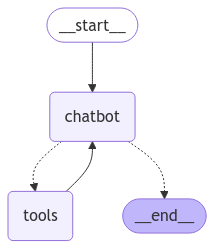

In [36]:
class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


# Define tool schema for human assistance
class HumanAssistanceInput(BaseModel):
    query: str = Field(..., description="The query to ask the human")


@tool(args_schema=HumanAssistanceInput)
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]

search_tool = TavilySearchResults(max_results=2)
tools = [search_tool, human_assistance]
llm = init_chat_model("gpt-4o-mini", model_provider="openai")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}


tool_node = ToolNode(tools=tools)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

### Request Human Assistance

In [37]:
user_input = "I need some expert guidance for building an AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_k8SIQXr8tKGOFO9qxtNZSnR1)
 Call ID: call_k8SIQXr8tKGOFO9qxtNZSnR1
  Args:
    query: I need expert guidance for building an AI agent. Can you provide insights or resources on the best practices, tools, and technologies available?


In [38]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

### Do not Request Human Assistance

In [43]:
user_input = "Who won the latest UT game"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Who won the latest UT game
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_TIpqasEcZcX147utV1SifW21)
 Call ID: call_TIpqasEcZcX147utV1SifW21
  Args:
    query: latest UT game result
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.secsports.com/scores/football/university-of-tennessee", "content": "The Commodores hold on for an 86-84 upset of Texas A&M on the road in College Station, giving them three wins over AP top-15 opponents for the first time since"}, {"url": "https://www.espn.com/college-football/team/_/id/2633/tennessee-volunteers", "content": "Visit ESPN for Tennessee Volunteers live scores, video highlights, and latest news. Find standings and the full 2025 season schedule."}]
================================== Ai Message ========

### Human Responds

In [ ]:
user_input = "I need some expert guidance for building an AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_k8SIQXr8tKGOFO9qxtNZSnR1)
 Call ID: call_k8SIQXr8tKGOFO9qxtNZSnR1
  Args:
    query: I need expert guidance for building an AI agent. Can you provide insights or resources on the best practices, tools, and technologies available?


In [39]:
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)

human_command = Command(resume={"data": human_response})

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_k8SIQXr8tKGOFO9qxtNZSnR1)
 Call ID: call_k8SIQXr8tKGOFO9qxtNZSnR1
  Args:
    query: I need expert guidance for building an AI agent. Can you provide insights or resources on the best practices, tools, and technologies available?
================================= Tool Message =================================
Name: human_assistance

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

For building an AI agent, it's recommended to explore **LangGraph**, as it is noted for being more reliable and extensible compared to simple autonomous agents. This tool may provide you with the resources and framework you need to construct a robust AI agent. If you have specific questions about fea

## Customizing State

Add properties to the state object.

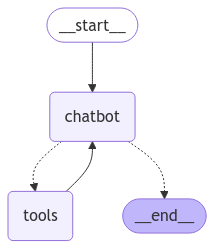

In [40]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    name: str
    birthday: str

graph_builder = StateGraph(State)


@tool
# Note that because we are generating a ToolMessage for a state update, we
# generally require the ID of the corresponding tool call. We can use
# LangChain's InjectedToolCallId to signal that this argument should not
# be revealed to the model in the tool's schema.
def human_assistance(name: str, birthday: str, tool_call_id: Annotated[str, InjectedToolCallId]) -> str:
    """Request assistance from a human."""
    human_response = interrupt(
        {
            "question": "Is this correct?",
            "name": name,
            "birthday": birthday,
        },
    )
    # If the information is correct, update the state as-is.
    if human_response.get("correct", "").lower().startswith("y"):
        verified_name = name
        verified_birthday = birthday
        response = "Correct"
    # Otherwise, receive information from the human reviewer.
    else:
        verified_name = human_response.get("name", name)
        verified_birthday = human_response.get("birthday", birthday)
        response = f"Made a correction: {human_response}"

    # This time we explicitly update the state with a ToolMessage inside
    # the tool.
    state_update = {
        "name": verified_name,
        "birthday": verified_birthday,
        "messages": [ToolMessage(response, tool_call_id=tool_call_id)],
    }
    # We return a Command object in the tool to update our state.
    return Command(update=state_update)


tool = TavilySearchResults(max_results=2)
tools = [tool, human_assistance]
llm = init_chat_model("gpt-4o-mini", model_provider="openai")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

In [41]:
user_input = (
    "Can you look up when LangGraph was released? "
    "When you have the answer, use the human_assistance tool for review."
)
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Can you look up when LangGraph was released? When you have the answer, use the human_assistance tool for review.
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_ycPn61LTCOMTVRslAC6mCnlv)
 Call ID: call_ycPn61LTCOMTVRslAC6mCnlv
  Args:
    query: LangGraph release date
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://github.com/langchain-ai/langgraph/releases", "content": "Releases · langchain-ai/langgraph · GitHub Search code, repositories, users, issues, pull requests... Releases: langchain-ai/langgraph Releases · langchain-ai/langgraph langgraph: release 0.2.70 (#3341) langgraph: add agent name to AI messages in create_react_agent (#3340) fix(langgraph): Dedupe input (right-side) messages in add_messages (#3338) Merge branch 'jacob/dedupe' of

In [42]:
human_command = Command(
    resume={
        "name": "LangGraph",
        "birthday": "Jan 17, 2024",
    },
)

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_ieRexPUEBoY9GnTVDRkPkATr)
 Call ID: call_ieRexPUEBoY9GnTVDRkPkATr
  Args:
    name: LangGraph
    birthday: 2025-02-06
================================= Tool Message =================================
Name: human_assistance

Made a correction: {'name': 'LangGraph', 'birthday': 'Jan 17, 2024'}
================================== Ai Message ==================================

LangGraph was released on January 17, 2024.


In [ ]:
snapshot = graph.get_state(config)

{k: v for k, v in snapshot.values.items() if k in ("name", "birthday")}

## Manually Updating State

In [ ]:
graph.update_state(config, {"name": "LangGraph (library)"})

In [ ]:
snapshot = graph.get_state(config)

{k: v for k, v in snapshot.values.items() if k in ("name", "birthday")}

## Time Travel

Time Travel allows users to branch off past states in the dialog interaction with an agent.

In [ ]:
class State(TypedDict):
    messages: Annotated[list, add_messages]


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder = StateGraph(State)
llm = init_chat_model("gpt-4o-mini", model_provider="openai")

tool = TavilySearchResults(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

### Create a State History

In [ ]:
config = {"configurable": {"thread_id": "1"}}
events = graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": (
                    "I'm learning LangGraph. "
                    "Could you do some research on it for me?"
                ),
            },
        ],
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

In [ ]:
events = graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": (
                    "Ya that's helpful. Maybe I'll "
                    "build an autonomous agent with it!"
                ),
            },
        ],
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

### Replay State History

Checkpoints are saved for every step of the graph.

In [ ]:
to_replay = None
for state in graph.get_state_history(config):
    print("Num Messages: ", len(state.values["messages"]), "Next: ", state.next)
    print("-" * 80)
    if len(state.values["messages"]) == 3:
        # We are somewhat arbitrarily selecting a specific state based on the number of chat messages in the state.
        to_replay = state

In [ ]:
print(to_replay.next)
print(to_replay.config)

In [ ]:
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    if "messages" in event:
        event["messages"][-1].pretty_print()